<a href="https://colab.research.google.com/github/aderdouri/PINNs/blob/master/Training/IPINNs/Inverse_PINNs_TVD_main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import math
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm
import torch
import torch.nn as nn

In [2]:
Nx= 200
#cfl= 0.2
tmax = 1 # time 0 ~ 1

#viscosity_coeff = (0.01/math.pi)
viscosity_coeff = 0.02

x = np.linspace(-1,1, 200)

#t = 0  , I.C
u = -1*np.sin(math.pi * x)
dx = abs(x[1]-x[0])

dt = 0.002# cfl * dx / np.max(np.abs(u))

nt = int(tmax/ dt) #+ 1

uf = np.zeros((nt,Nx))
uf[0, :] = u

print(nt)
print(dt)
print(nt * dt, tmax )

500
0.002
1.0 1


In [3]:
def f(u):
    y = 0.5 * u**2
    yp = u
    return y, yp

In [4]:
def minmod(a,b):
    return 0.5 * (np.sign(a)+ np.sign(b)) * np.minimum(np.abs(a), np.abs(b))

In [5]:
def RHS(u, dx, viscosity_coeff):
    #diffusion term
    diffusion_term = viscosity_coeff * (np.roll(u,1)- 2*u + np.roll(u,-1))/ dx**2

    ux = minmod((u - np.roll(u,1))/dx ,  (np.roll(u,-1) - u)/dx)

    uL = np.roll(u -0.5 * dx*ux,1)
    uR = u -0.5 * dx*ux
    fL,fpL = f(uL)
    fR,fpR = f(uR)
    a = np.maximum(np.abs(fpL), np.abs(fpR))

    H =0.5 * (fL + fR - a * (uR - uL))

    conv_term  = -(np.roll(H,-1)-H)/dx

    y = conv_term + diffusion_term
    return y

In [6]:
for i in range(1, nt):
    u1 = u + dt * RHS(u,dx,viscosity_coeff)
    u = 0.5 * u + 0.5 * (u1 + dt * RHS(u1, dx,viscosity_coeff))
    uf[i, :] = u

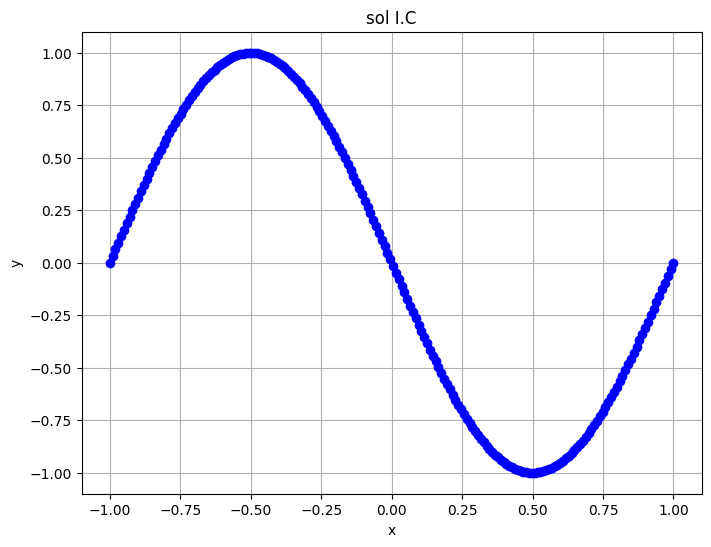

In [7]:
plt.figure(figsize=(8,6))
plt.plot(x, uf[0], '-o', color = 'b')
plt.title("sol I.C")
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)
plt.show()

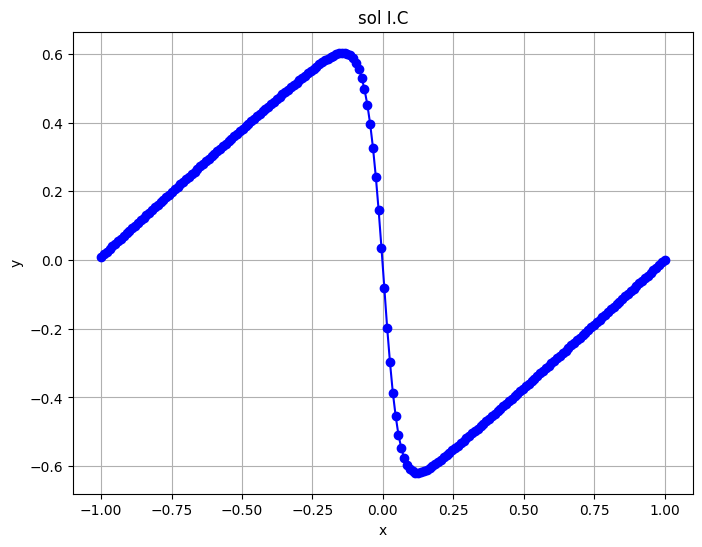

In [8]:
plt.figure(figsize=(8,6))
plt.plot(x, uf[-1], '-o', color = 'b')
plt.title("sol I.C")
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)
plt.show()

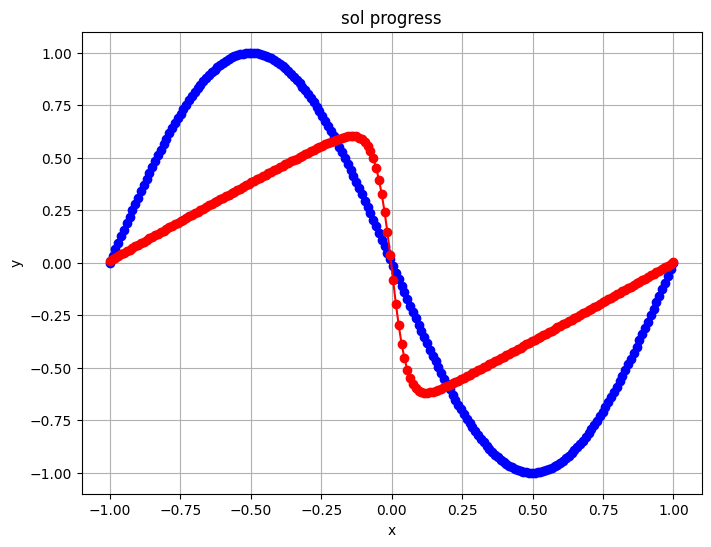

In [9]:
plt.figure(figsize=(8,6))
plt.plot(x, uf[0], '-o', color = 'b')
plt.plot(x, uf[-1], '-o', color = 'r')
plt.title("sol progress")
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)
plt.show()

In [10]:
uf

array([[ 1.22464680e-16,  3.15685498e-02,  6.31056313e-02, ...,
        -6.31056313e-02, -3.15685498e-02, -1.22464680e-16],
       [ 5.04816912e-03,  3.39789169e-02,  6.29057353e-02, ...,
        -6.26316775e-02, -3.39141776e-02, -4.99532216e-03],
       [ 8.06837905e-03,  3.55817910e-02,  6.32706630e-02, ...,
        -6.28071191e-02, -3.54144418e-02, -7.93565334e-03],
       ...,
       [ 8.80213458e-03,  1.65360123e-02,  2.42552594e-02, ...,
        -1.44125704e-02, -6.68651117e-03,  1.05285876e-03],
       [ 8.79440206e-03,  1.65166666e-02,  2.42243446e-02, ...,
        -1.43854607e-02, -6.67097320e-03,  1.05678648e-03],
       [ 8.78668460e-03,  1.64973705e-02,  2.41935139e-02, ...,
        -1.43584398e-02, -6.65548965e-03,  1.06069439e-03]])

In [11]:
tf = np.linspace(0,1, nt)

In [12]:
#tf

In [13]:
xf = x

In [14]:
#xf

In [15]:
tf_tensor = torch.tensor(tf)
xf_tensor = torch.tensor(xf)

print(len(tf_tensor))
print(len(xf_tensor))

combined_tensor_x_train = torch.empty((len(tf)*len(xf), 2), dtype= torch.float32)

index = 0
for i in range(len(tf)):
    for j in range(len(xf)):
        combined_tensor_x_train[index][0] = xf_tensor[j]
        combined_tensor_x_train[index][1] = tf_tensor[i]
        index= index +1

print(len(combined_tensor_x_train))

500
200
100000


In [16]:
#tf_tensor
#xf_tensor
combined_tensor_x_train
#len(combined_tensor_x_train)

tensor([[-1.0000,  0.0000],
        [-0.9899,  0.0000],
        [-0.9799,  0.0000],
        ...,
        [ 0.9799,  1.0000],
        [ 0.9899,  1.0000],
        [ 1.0000,  1.0000]])

In [17]:
your_tensor = torch.tensor(uf, dtype= torch.float32)

flattened_tensor_y_train = your_tensor.view(-1)
flattened_tensor_y_train = flattened_tensor_y_train.unsqueeze(1)

print(len(flattened_tensor_y_train))

100000


In [18]:
#your_tensor
flattened_tensor_y_train

tensor([[ 1.2246e-16],
        [ 3.1569e-02],
        [ 6.3106e-02],
        ...,
        [-1.4358e-02],
        [-6.6555e-03],
        [ 1.0607e-03]])

In [19]:
lambda_value = 2.0
print("the real value =",viscosity_coeff, "     Our I-PINNs value=", lambda_value)

the real value = 0.02      Our I-PINNs value= 2.0


In [20]:
class NN(nn.Module):
    def __init__(self):
        super(NN, self).__init__()
        self.net = torch.nn.Sequential(
            nn.Linear(2,20),
            nn.Tanh(),
            nn.Linear(20,30),
            nn.Tanh(),
            nn.Linear(30,20),
            nn.Tanh(),
            nn.Linear(20,20),
            nn.Tanh(),
            nn.Linear(20,1),
            nn.Tanh(),
        )

    def forward(self, x):
        out = self.net(x)
        return out

In [22]:
class Net:
    def __init__(self):
        device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")



        self.lambda_value = torch.tensor([lambda_value], requires_grad=True).float().to(device)

        self.lambda_value = nn.Parameter(self.lambda_value)

        self.model = NN().to(device)

        self.model.register_parameter('lambda_value', self.lambda_value)

        self.h = 0.1
        self.k = 0.1
        x = torch.arange(-1,1+self.h, self.h)
        t = torch.arange(0,1+self.k, self.k)

        self.X = torch.stack(torch.meshgrid(x,t)).reshape(2,-1).T

        #################### Input the data #################
        self.X_train = combined_tensor_x_train
        self.y_train = flattened_tensor_y_train
        #####################################################

        self.X = self.X.to(device)
        self.X.requires_grad = True

        self.X_train= self.X_train.to(device)
        self.y_train= self.y_train.to(device)


        self.adam = torch.optim.Adam(self.model.parameters())

        self.criterion = torch.nn.MSELoss()

        self.iter = 1

    def loss_func(self):
        self.adam.zero_grad()

        #####################
        y_pred = self.model(self.X_train)
        loss_data = self.criterion(y_pred, self.y_train)
        #####################



        u = self.model(self.X)

        du_dX = torch.autograd.grad(
            u,
            self.X,
            grad_outputs = torch.ones_like(u),
            create_graph = True,
            retain_graph = True
        )[0]

        du_dt = du_dX[:,1]
        du_dx = du_dX[:,0]

        du_dXX = torch.autograd.grad(
            du_dX,
            self.X,
            grad_outputs = torch.ones_like(du_dX),
            create_graph = True,
            retain_graph = True
        )[0]

        du_dxx = du_dXX[:,0]


        lambda_pde  = self.lambda_value

        loss_pde = self.criterion(du_dt+ 1 * u.squeeze()*du_dx, lambda_pde* du_dxx)

        loss = loss_pde + loss_data
        loss.backward()

        if self.iter % 100 == 0:
            print("iteration number =",self.iter, " loss value =", loss.item(), "real mu=",
                  viscosity_coeff,"IPINN lambda=", self.lambda_value.item())

        self.iter= self.iter + 1

        return loss

    def train(self):
        self.model.train()

        for i in range(5000):
            self.adam.step(self.loss_func)

    def eval_(self):
        self.model.eval()

In [23]:
net = Net()
net.train()
net.model.eval()

/usr/local/lib/python3.10/dist-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3595.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


iteration number = 100  loss value = 0.19766388833522797 real mu= 0.02 IPINN lambda= 1.9100158214569092
iteration number = 200  loss value = 0.1909307837486267 real mu= 0.02 IPINN lambda= 1.85563325881958
iteration number = 300  loss value = 0.17687490582466125 real mu= 0.02 IPINN lambda= 1.7993582487106323
iteration number = 400  loss value = 0.16210705041885376 real mu= 0.02 IPINN lambda= 1.7242754697799683
iteration number = 500  loss value = 0.15656442940235138 real mu= 0.02 IPINN lambda= 1.6229192018508911
iteration number = 600  loss value = 0.1544095277786255 real mu= 0.02 IPINN lambda= 1.5077979564666748
iteration number = 700  loss value = 0.15241330862045288 real mu= 0.02 IPINN lambda= 1.3843661546707153
iteration number = 800  loss value = 0.14993897080421448 real mu= 0.02 IPINN lambda= 1.2501980066299438
iteration number = 900  loss value = 0.14652830362319946 real mu= 0.02 IPINN lambda= 1.1019067764282227
iteration number = 1000  loss value = 0.14164689183235168 real mu= 0

NN(
  (net): Sequential(
    (0): Linear(in_features=2, out_features=20, bias=True)
    (1): Tanh()
    (2): Linear(in_features=20, out_features=30, bias=True)
    (3): Tanh()
    (4): Linear(in_features=30, out_features=20, bias=True)
    (5): Tanh()
    (6): Linear(in_features=20, out_features=20, bias=True)
    (7): Tanh()
    (8): Linear(in_features=20, out_features=1, bias=True)
    (9): Tanh()
  )
)

In [24]:
h = 0.01
k = 0.01

x = torch.arange(-1,1,h)
t = torch.arange(0,1,k)

X= torch.stack(torch.meshgrid(x,t)).reshape(2,-1).T
X= X.to(net.X.device)

model = net.model
model.eval()
with torch.no_grad():
    y_pred = model(X)
    y_pred = y_pred.reshape(len(x),len(t)).cpu().numpy()

In [25]:
y_pred_inverse = y_pred

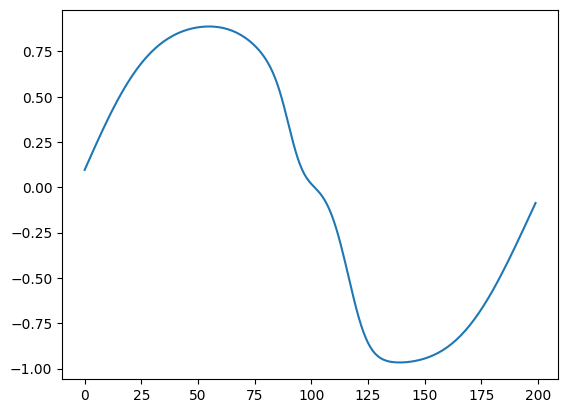

In [26]:
#I.C
plt.plot(y_pred_inverse[:,0])

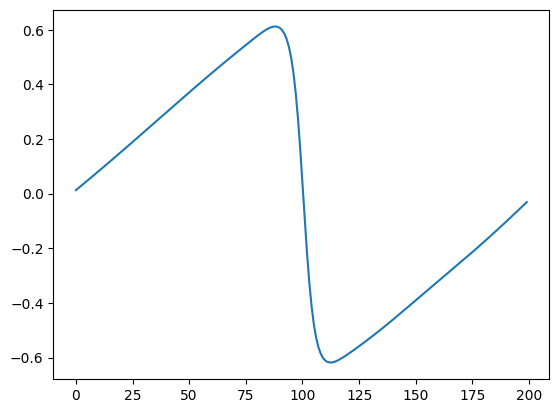

In [27]:
#I.C
plt.plot(y_pred_inverse[:,-1])

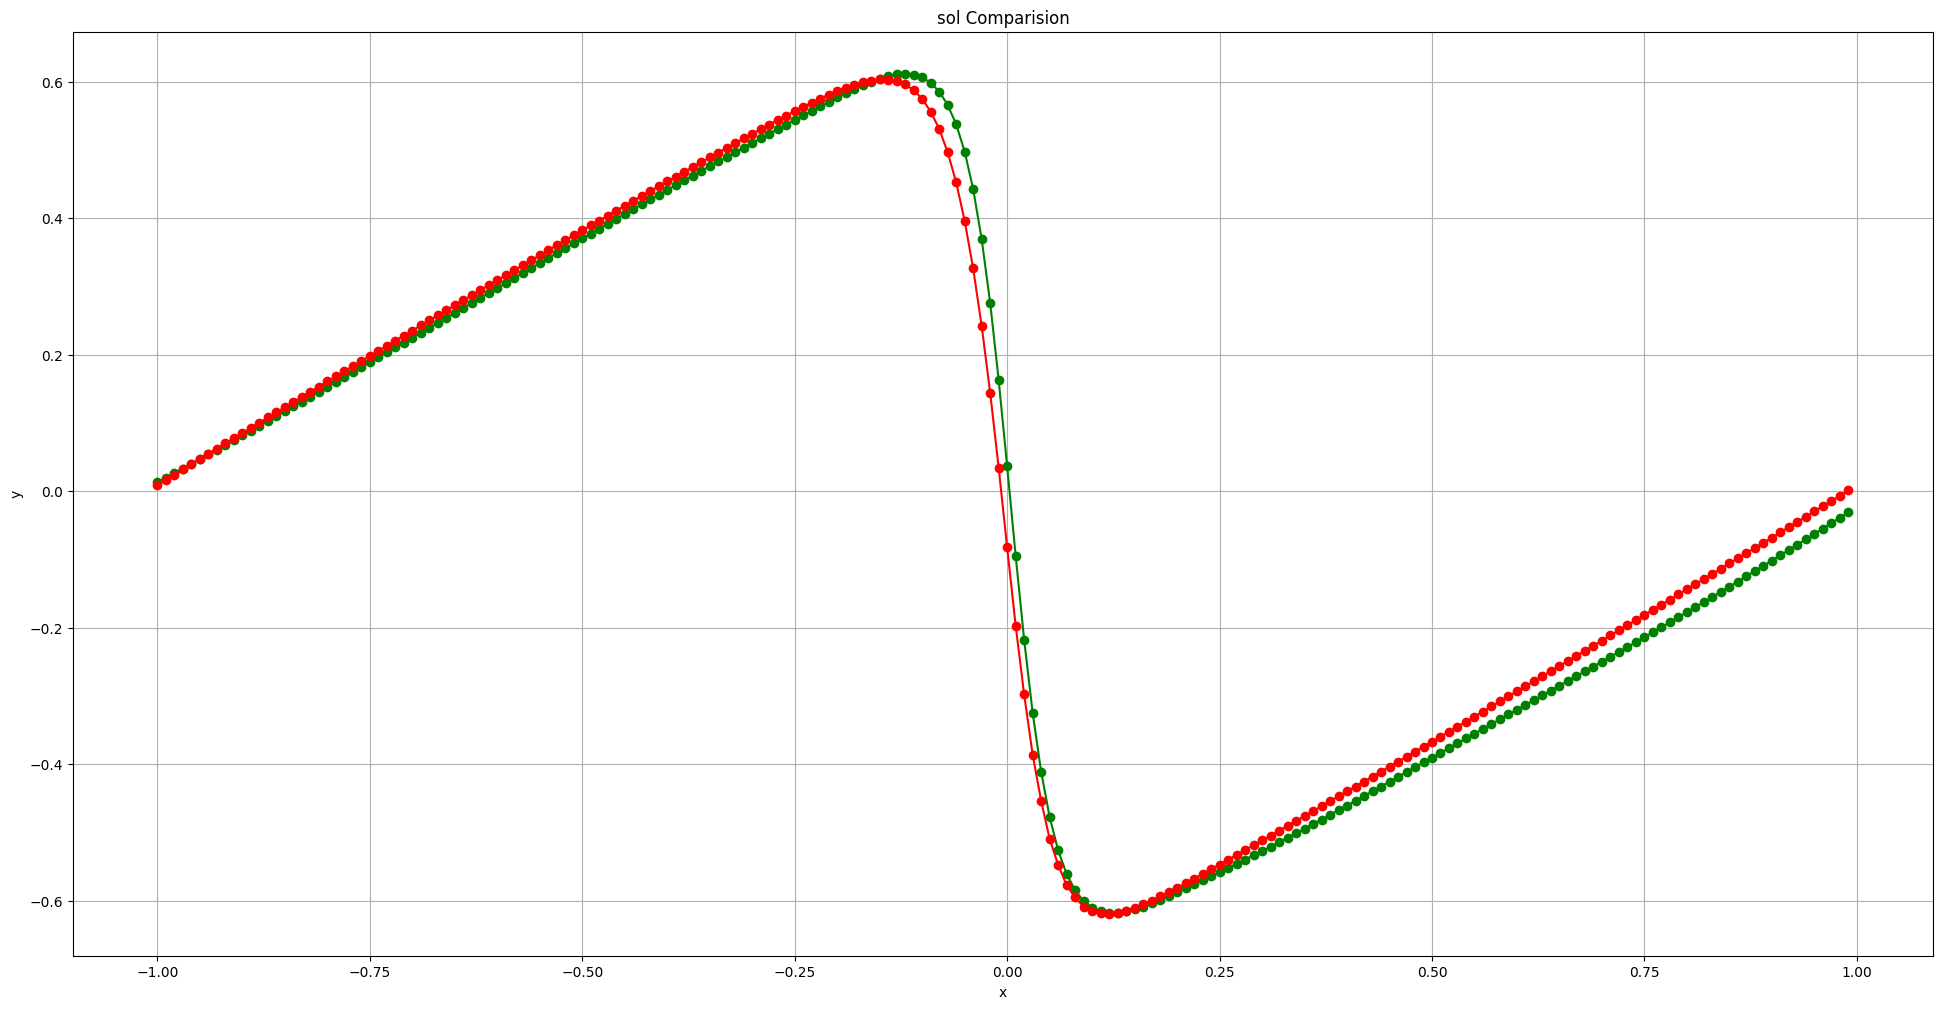

In [28]:
plt.figure(figsize=(24,12))
plt.plot(x, y_pred_inverse[:,-1], '-o', color = 'g') #IPINNs
plt.plot(x, uf[-1], '-o', color = 'r') #TVD
plt.title("sol Comparision")
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)
plt.show()

In [29]:
sns.set_style("white")
plt.figure(figsize=(5,3), dpi=3000)
sns.heatmap(y_pred_inverse, cmap='jet')

<Axes: >

In [30]:
class NN(nn.Module):
    def __init__(self):
        super(NN, self).__init__()
        self.net = torch.nn.Sequential(
            nn.Linear(2,20),
            nn.Tanh(),
            nn.Linear(20,30),
            nn.Tanh(),
            nn.Linear(30,30),
            nn.Tanh(),
            nn.Linear(30,20),
            nn.Tanh(),
            nn.Linear(20,20),
            nn.Tanh(),
            nn.Linear(20,1)
        )

    def forward(self, x):
        out = self.net(x)
        return out

In [31]:
class Net:
    def __init__(self):
        device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

        self.model = NN().to(device)

        # comp. domain
        self.h = 0.1
        self.k = 0.1
        x = torch.arange(-1,1+self.h, self.h)
        t = torch.arange(0,1+self.k, self.k)

        self.X = torch.stack(torch.meshgrid(x,t)).reshape(2,-1).T

        # train data
        bc1 = torch.stack(torch.meshgrid(x[0],t)).reshape(2,-1).T
        bc2 = torch.stack(torch.meshgrid(x[-1],t)).reshape(2,-1).T
        ic  = torch.stack(torch.meshgrid(x,t[0])).reshape(2,-1).T
        self.X_train = torch.cat([bc1, bc2, ic])

        y_bc1 = torch.zeros(len(bc1))
        y_bc2 = torch.zeros(len(bc2))
        y_ic  = -torch.sin(math.pi * ic[:,0])
        print(y_ic)

        self.y_train = torch.cat([y_bc1, y_bc2, y_ic])
        self.y_train = self.y_train.unsqueeze(1)

        self.X = self.X.to(device)
        self.y_train = self.y_train.to(device)
        self.X_train = self.X_train.to(device)
        self.X.requires_grad = True

        # optimizer setting
        self.adam =  torch.optim.Adam(self.model.parameters())
        #Limited-memory Broyden-Fletcher-Goldfarb-Shanno (L-BFGS)
        self.optimizer = torch.optim.LBFGS(
            self.model.parameters(),
            lr=1.0,
            max_iter = 50000,
            max_eval = 50000,
            history_size = 50,
            tolerance_grad = 1e-15,
            tolerance_change = 1.0* np.finfo(float).eps,
            line_search_fn ="strong_wolfe"
        )

        self.criterion = torch.nn.MSELoss()
        self.iter = 1

    def loss_func(self):
        self.adam.zero_grad()
        self.optimizer.zero_grad()

        y_pred = self.model(self.X_train)
        loss_data = self.criterion(y_pred,self.y_train)

        u = self.model(self.X)

        du_dX = torch.autograd.grad(
            u,
            self.X,
            grad_outputs = torch.ones_like(u),
            create_graph = True,
            retain_graph = True
        )[0]

        #print(du_dX)
        #print("xxxxxxxxxxxxxxxxxxxxxxxxx")
        #print(du_dX[0])

        du_dt = du_dX[:,1]
        du_dx = du_dX[:,0]

        du_dXX = torch.autograd.grad(
            du_dX,
            self.X,
            grad_outputs = torch.ones_like(du_dX),
            create_graph = True,
            retain_graph = True
        )[0]

        du_dxx = du_dXX[:,0]

        #loss_pde = self.criterion(du_dt + 1*u.squeeze()*du_dx , (0.01/math.pi) * du_dxx)
        loss_pde = self.criterion(du_dt + 1*u.squeeze()*du_dx , (0.02) * du_dxx)

        loss = loss_pde + loss_data
        loss.backward()

        if self.iter % 100 == 0:
            print(self.iter, loss.item())
        self.iter = self.iter+1

        return loss

    def train(self):
        self.model.train()
        for i in range(3000):
            self.adam.step(self.loss_func)
        self.optimizer.step(self.loss_func)

    def eval_(self):
        self.model.eval()

In [32]:
# training
net = Net()
net.train()
net.model.eval()

tensor([-8.7423e-08,  3.0902e-01,  5.8779e-01,  8.0902e-01,  9.5106e-01,
         1.0000e+00,  9.5106e-01,  8.0902e-01,  5.8779e-01,  3.0902e-01,
         9.3627e-09, -3.0902e-01, -5.8779e-01, -8.0902e-01, -9.5106e-01,
        -1.0000e+00, -9.5106e-01, -8.0902e-01, -5.8779e-01, -3.0902e-01,
         8.7423e-08])
100 0.09935670346021652
200 0.0527258962392807
300 0.03825213760137558
400 0.032489292323589325
500 0.024931706488132477
600 0.02213091403245926
700 0.024962972849607468
800 0.017238421365618706
900 0.01570066809654236
1000 0.014469191431999207
1100 0.013686615973711014
1200 0.015828553587198257
1300 0.01175813376903534
1400 0.011116592213511467
1500 0.010681827552616596
1600 0.010954154655337334
1700 0.009302401915192604
1800 0.008944347500801086
1900 0.008299732580780983
2000 0.007866454310715199
2100 0.008064519613981247
2200 0.006987651810050011
2300 0.006807208992540836
2400 0.006306169554591179
2500 0.006312994286417961
2600 0.00566469132900238
2700 0.005498870275914669
2

NN(
  (net): Sequential(
    (0): Linear(in_features=2, out_features=20, bias=True)
    (1): Tanh()
    (2): Linear(in_features=20, out_features=30, bias=True)
    (3): Tanh()
    (4): Linear(in_features=30, out_features=30, bias=True)
    (5): Tanh()
    (6): Linear(in_features=30, out_features=20, bias=True)
    (7): Tanh()
    (8): Linear(in_features=20, out_features=20, bias=True)
    (9): Tanh()
    (10): Linear(in_features=20, out_features=1, bias=True)
  )
)

In [33]:
h = 0.01
k = 0.01

x = torch.arange(-1,1,h)
t = torch.arange(0,1,k)

X= torch.stack(torch.meshgrid(x,t)).reshape(2,-1).T
X= X.to(net.X.device)

model = net.model
model.eval()
with torch.no_grad():
    y_pred = model(X)
    y_pred = y_pred.reshape(len(x),len(t)).cpu().numpy()

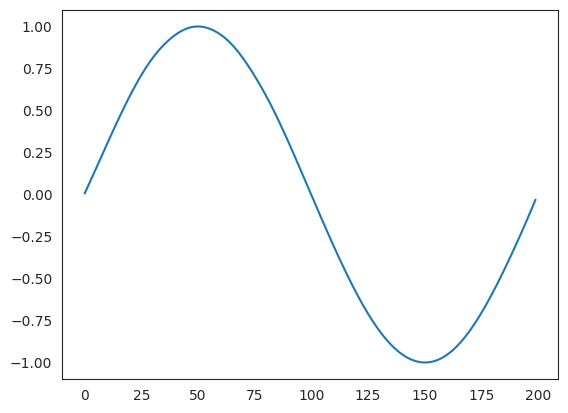

In [34]:
#I.C
plt.plot(y_pred[:,0])

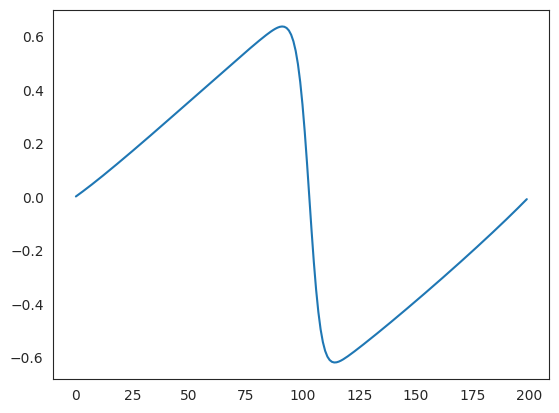

In [35]:
#final.sol
plt.plot(y_pred[:,-1])

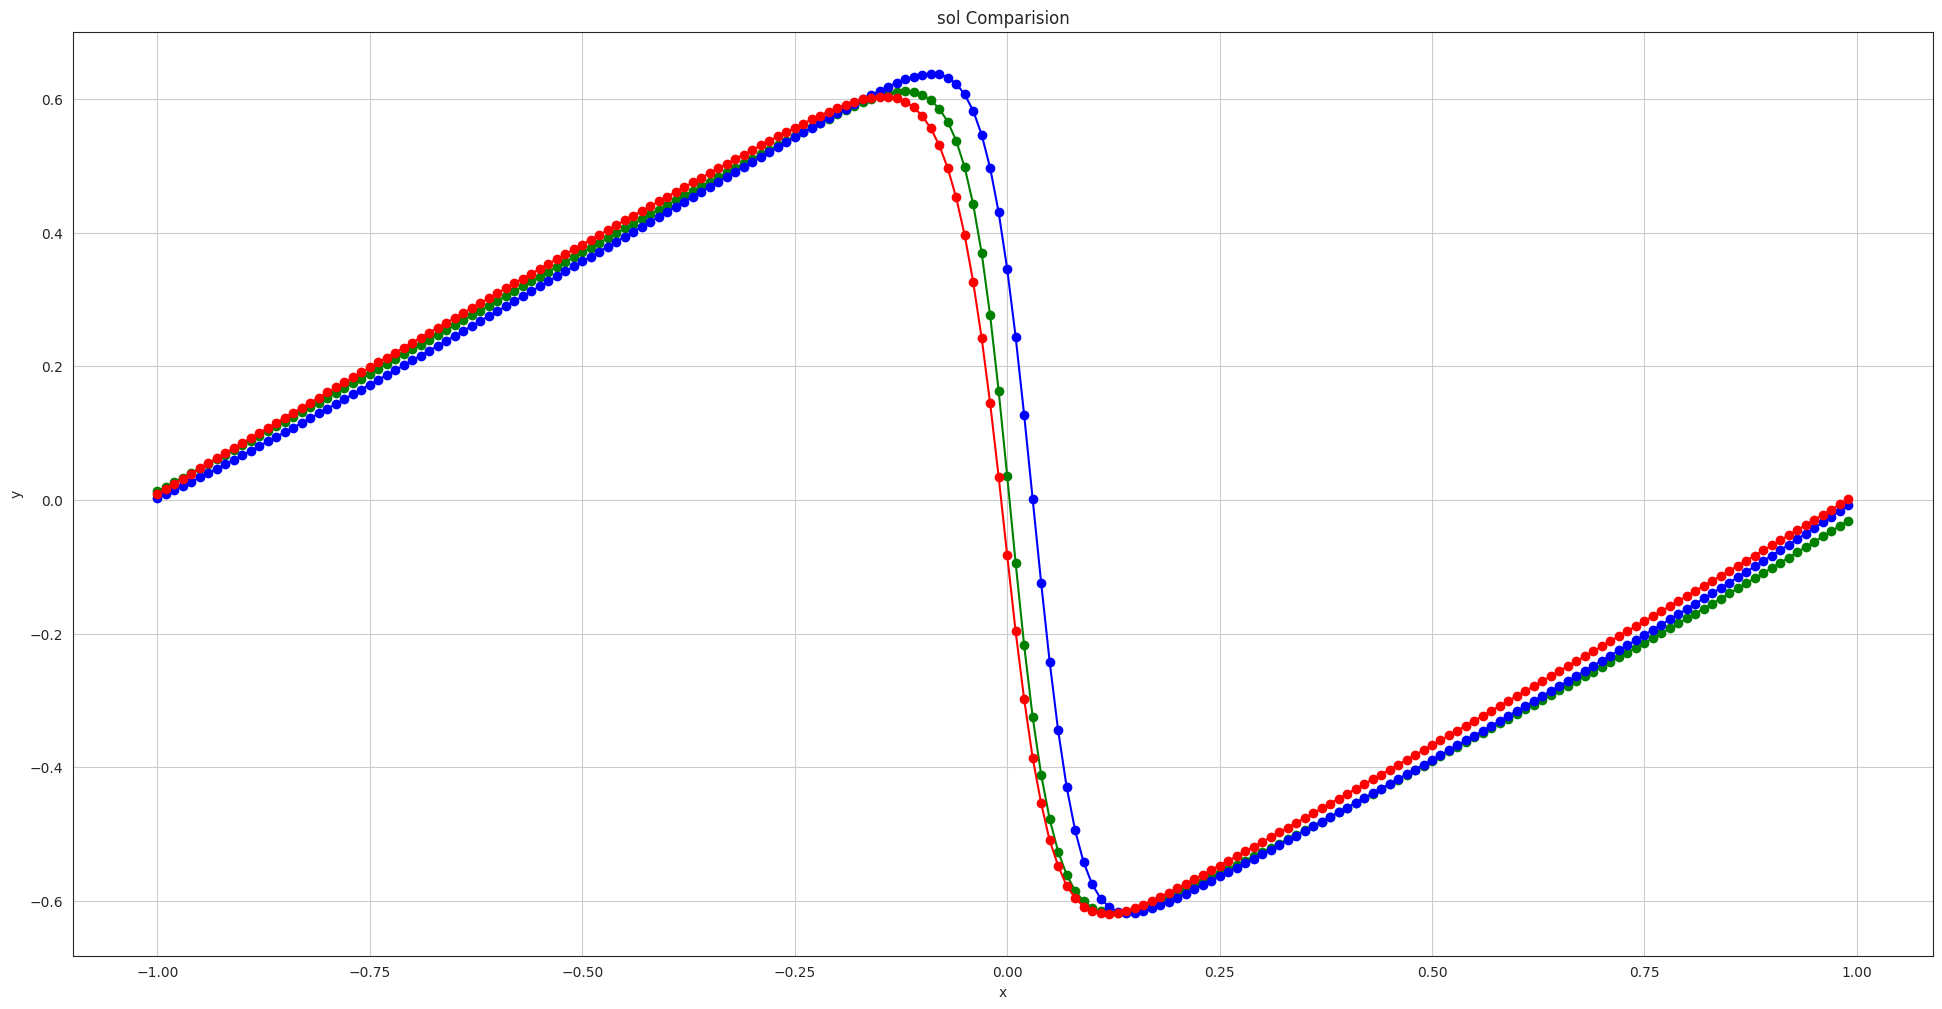

In [36]:
plt.figure(figsize=(24,12))

plt.plot(x, y_pred_inverse[:,-1], '-o', color = 'g') #IPINNs
plt.plot(x, y_pred[:,-1], '-o', color = 'b') #PINNs
plt.plot(x, uf[-1], '-o', color = 'r') #TVD

plt.title("sol Comparision")
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)
plt.show()